# TP 6 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [24]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *
import cv2

In [25]:
from functions import *

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
flags = [i for i in dir(cv2) if i.startswith("COLOR_")]

In [28]:
len(flags)

346

In [29]:
flags[40]

'COLOR_BAYER_GR2GRAY'

### Nemo Segmentation

In [30]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb

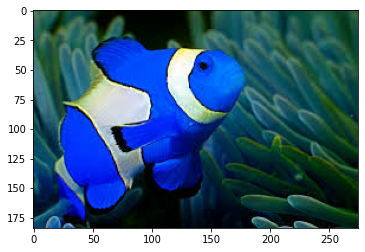

In [31]:
nemo = cv2.imread("img/nemo0.jpg")
plt.imshow(nemo)
plt.show()

OpenCV lee por defecto las imagenes en BGR, por lo cual es necesario una conversión a RGB para poder visualizarla correctamente.

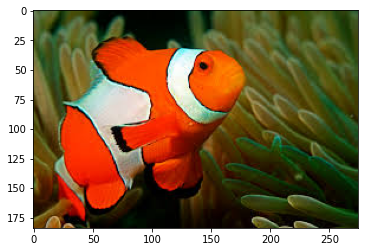

In [32]:
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
plt.imshow(nemo)
plt.show()

Si proyectamos los valores de color RGB como coordenadas en el espacio, donde por ejemplo, un pixel rojo tendrá coordenadas (255, 0, 0), y uno negro tendrá (0, 0, 0). Obtendremos una distribución de pixeles en el espacio.

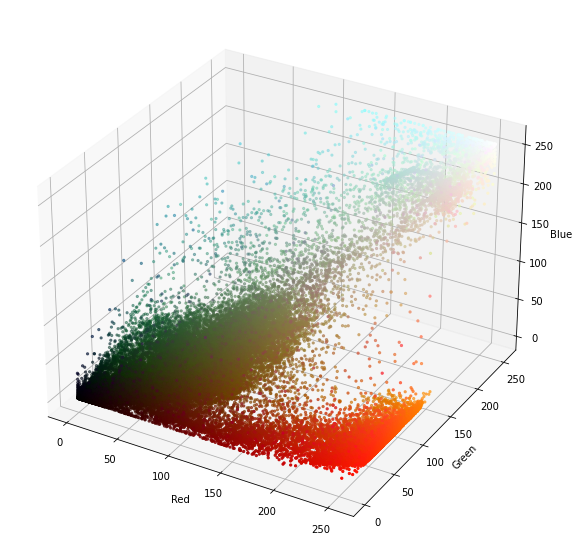

In [33]:
# Splitting components of image
r, g, b = cv2.split(nemo)

# Creating Figure for 3D plot
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection='3d')

# Normalising list of pixels
pixel_colors = nemo.reshape((np.shape(nemo)[0] * np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

# Plotting
axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker='.')
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

Si bien, el sistema RGB es más facil de entender por nosotros y es ampliamente usado para la representación de colores, no es tan util para segmentar un color en particular. Esta tarea es más sencilla si convertimos la imágen al sistema HSV, para poder segmentar un color.

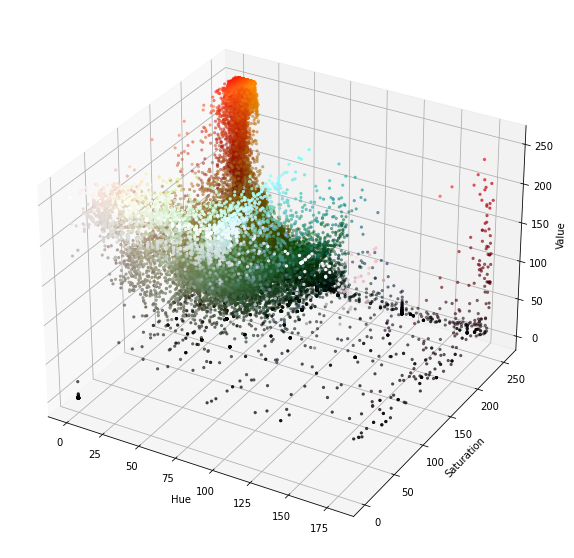

In [34]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_nemo)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

Para el segundo gráfico se mantuvo la misma paleta de colores de los puntos, para poder ver que la separación del naranja en HSV es más apreciable.
A continuación se aplica una máscara para poder segmentar el color naranja de la imágen.

In [35]:
# Thresholds for segmenting Nemo
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)

In [36]:
# Segmenting Nemo according to thresholds, using a mask
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
segmented_nemo = cv2.bitwise_and(nemo, nemo, mask=mask)

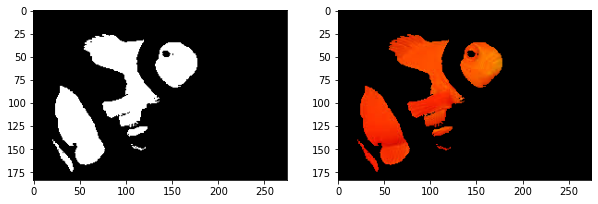

In [37]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_nemo)
plt.show()

Ahora se aplica una máscara para poder segmentar el color blanco de la imágen.

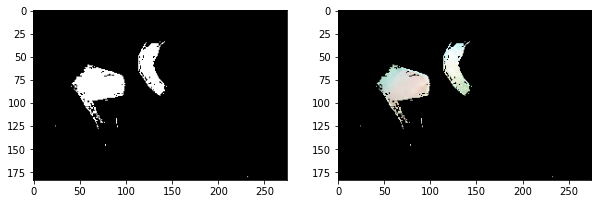

In [38]:
# Segmenting white stripes of Nemo
light_white = (0, 0, 200)
dark_white = (145, 60, 255)

mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

Ahora utilizando ambas máscaras, se obtiene la segmentación completa de Nemo.

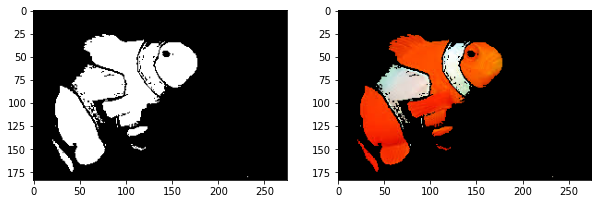

In [39]:
# Segmenting both white and orange parts of Nemo
final_mask = mask + mask_white
final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

Aparecen unos puntos negros no deseados en la segmentación, para reducirlos se aplica un pasabajos gausseano que nos da una imágen más continua, sacando esas falsas detecciones.

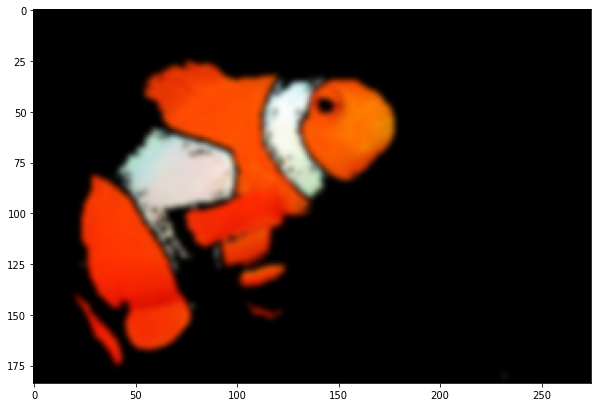

In [40]:
# Blurring to smoothen dark dots in the middle of Nemo
blur = cv2.GaussianBlur(final_result, (7, 7), 0)

fig = plt.figure(figsize=(10,10))
plt.imshow(blur)
plt.show()

Ahora probamos todo este mismo procedimiento pero con otra imágen.

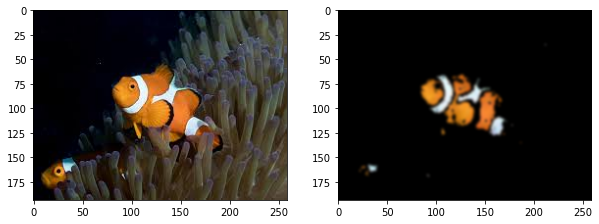

In [41]:
nemos_friend = cv2.imread("img/nemo5.jpg")
nemos_friend = cv2.cvtColor(nemos_friend, cv2.COLOR_BGR2RGB)
result = segment_fish(nemos_friend)
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(nemos_friend)
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Se puede ver como la segmentación para una imágen de un pez con cierta luz, tono y fondo no puede ser generalizado para cualquier imágen, pero si una aproximación aceptable. 

# 1-b

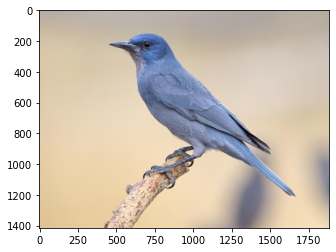

In [42]:
bird = cv2.imread("img/bird.jpg")
bird = cv2.cvtColor(bird, cv2.COLOR_BGR2RGB)
plt.imshow(bird)
plt.show()

Convertimos a HSV para poder segmentar el color

In [43]:
hsv_bird = cv2.cvtColor(bird, cv2.COLOR_RGB2HSV) # Convert the image from RGB to HSV

In [46]:
# Normalising list of pixels
pixel_colors_bird = bird.reshape((np.shape(bird)[0] * np.shape(bird)[1], 3))
norm = colors.Normalize(vmin=-1., vmax=1.)
norm.autoscale(pixel_colors_bird)
pixel_colors = norm(pixel_colors_bird).tolist()

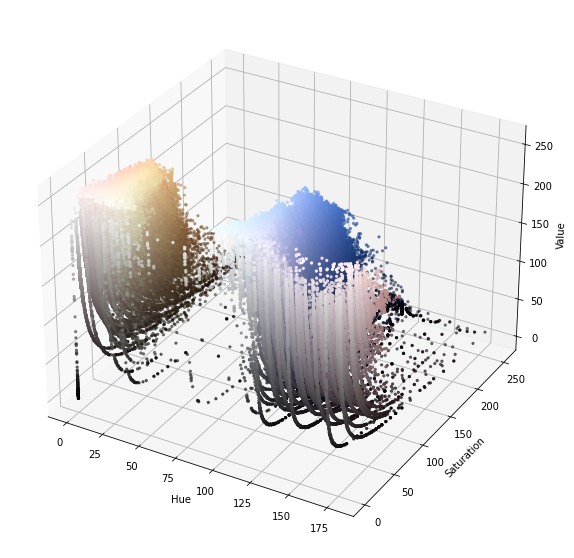

In [48]:
# Plotting distribution of pixels in 3D HSV colour space
h, s, v = cv2.split(hsv_bird)
fig = plt.figure(figsize=(10,10))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [53]:
# Thresholds for segmenting Bird
light_blue = (75, 0, 0) #change
dark_blue = (160, 255, 255)


In [54]:
# Segmenting bird according to thresholds, using a mask
mask = cv2.inRange(hsv_bird, light_blue, dark_blue)
segmented_bird = cv2.bitwise_and(bird, bird, mask=mask)

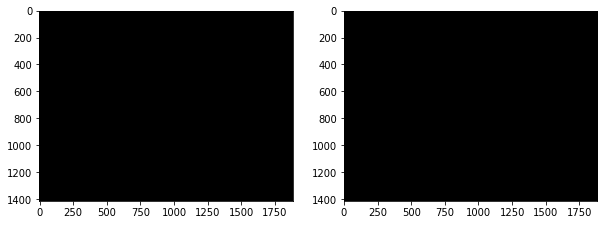

In [56]:
fig = plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmented_bird)
plt.show()